# Identifying articles related to health and Wellness.

From the exam instructions:
Imagine you're working at a media buying company, Chrishare. They have a new client, 
Theragun
. 

Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. So, they’d like to find health and wellness news around the web to advertise on. Their goal with their media campaign is to identify as many news articles that mention health and wellness as possible. 

This is called contextual advertising: finding the URLs that match the context in which you’d like your ad to be shown. 

Your challenge now is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. You’ll be using the 
k-train
, which is a wrapper for 
Tensorflow
, 
Keras
, and 
Huggingface Transformers
.

### First we load  and import all the libraries that will be neede for this project. 

In [65]:
import os
import tensorflow as tf
import ktrain
import pandas as pd
import numpy as np
import pickle
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import glob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


Load the google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Load the json data file to a pandas dataframe and see whats inside.

In [2]:
news = pd.read_json("news_category_trainingdata.json")
 

An inspection of what the data frame contains, shows it's news articles that have been previously put in different news categories, it also contains both the headline and a short description of the content of the article as well as the authors, a link to the article and the date. 

In [3]:
news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


We can see how many different categories of articles are in the dataframe, and how many articles of each category. 

In [5]:
news.groupby('category').count()

,headline,authors,link,short_description,date
category,,,,,
ARTS,1509,1509,1509,1509,1509
ARTS & CULTURE,1339,1339,1339,1339,1339
BLACK VOICES,4528,4528,4528,4528,4528
BUSINESS,5937,5937,5937,5937,5937
COLLEGE,1144,1144,1144,1144,1144
COMEDY,5175,5175,5175,5175,5175
CRIME,3405,3405,3405,3405,3405
CULTURE & ARTS,1030,1030,1030,1030,1030
DIVORCE,3426,3426,3426,3426,3426


We are interesd in health and wellness, so the categories we will try to predict are healthy living and wellness. We can see there are a lot of wellness articles 17827, while only 6694 of healthy livining, so we have almost 3 times the amount of articles on wellness than of healthy living. 

Prepare the data combining the headline and the short description to use it as the feature the models will use to predict if the news article belongs to health and wellness or not. 

In [6]:
news['combined_text'] = news['headline'] + ' ' + news['short_description']



You need health and wellness, that would be healthy living and wellness. A binary column is created with a 1 if it belongs to either category healthy living or wellness. 

In [7]:
news['hw'] = np.where((news['category'].isin(['HEALTHY LIVING',"WELLNESS"])),1,0)


In [8]:
news['hw'].describe()


count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: hw, dtype: float64

The data is clearly unbalanced as our ones (health and wellness) are only 12% of the data, so we select a smaller sample of the non health and wellness to keep a balanced data set. I tried different combinations of samples of the data, increasing the amount of data that didn/t belong to health and wellness in the trainning increased the precision of the 0 (not health and wellness) results but decreased the preciosion of the ones (health and wellness) so I decided the best was to keep it almost 50/50 balanced as it seemed to get the best overall results. 

In [153]:
hw.combined_text[148168]

"4 Surprisingly Simple Steps to Forgive Anyone for Anything People and situations show up in our lives so we can learn and grow. Though I wouldn't encourage you to seek out pain, it's not something to avoid either. It's just part of life -- and it can be a gift."

In [22]:
#Amount of available articles of health and wellnes
sample_amount = len(news[news["hw"] == 1])
#get all the health and wellness articles. 
hw = news[news['hw'] == 1].sample(n=sample_amount)
#not_hw = news[news['hw'] == 0].sample(n=sample_amount) first model
#Randomly get some not health and wellness articles. 
not_hw = news[news['hw'] == 0].sample(n=sample_amount+5000, random_state = 34)

#Create new data frame with the sample
news_sample = pd.concat([hw,not_hw])

#shuffle the data frame. 
news_sample = news_sample.sample(frac = 1, random_state = 13)
news_sample.describe()



,date,hw
count,54042,54042.00000
mean,2014-09-02 14:13:48.955257088,0.45374
min,2012-01-28 00:00:00,0.00000
25%,2013-03-13 00:00:00,0.00000
50%,2014-04-05 00:00:00,0.00000
75%,2016-02-08 00:00:00,1.00000
max,2018-05-26 00:00:00,1.00000
std,NaN,0.49786


The data is now 45% health and wellness and the columns that will be used to create the models are combined_text and hw, below are the first 5 articles. 

In [24]:
news_sample[['category','combined_text','hw']].head()


,category,combined_text,hw
197443,WELLNESS,'The Hunger Games' Star Jennifer Lawrence Not ...,1
54355,TASTE,Happy Farro July! If you are looking for a one...,0
98790,ENTERTAINMENT,Video Premiere: Pieta Brown Presents 'Flowers ...,0
85710,HEALTHY LIVING,The One Thing Brandy Does Every Day To Find Ba...,1
126708,ENTERTAINMENT,'Frozen' Is Officially The Highest-Grossing An...,0


I separated 10% of the data for the test/validation and kept the other 90 for trainning  before creating any model, so all the models are consistent and are trainned and tested using the same data. 

In [29]:
#Keep some data to test the model as it is not clear that we are.
#First we shuffle all the columns, and then we keep the first 1000 testing at the end
#Version2 has n//10
set_seed = 12
msk = np.random.rand(len(news_sample)) < 0.9
train_df = news_sample[msk]
test_df = news_sample[~msk]
#n_len = len(review_sample)
#test = review_sample[:n_len//10]
#review_sample = review_sample[n_len//10:]
train_df.describe()

,date,hw
count,48625,48625.000000
mean,2014-09-03 14:54:46.161439488,0.453039
min,2012-01-28 00:00:00,0.000000
25%,2013-03-14 00:00:00,0.000000
50%,2014-04-07 00:00:00,0.000000
75%,2016-02-10 00:00:00,1.000000
max,2018-05-25 00:00:00,1.000000
std,NaN,0.497795


In [30]:
test_df.describe()

,date,hw
count,5417,5417.000000
mean,2014-08-24 08:40:13.734539264,0.460033
min,2012-01-28 00:00:00,0.000000
25%,2013-03-04 00:00:00,0.000000
50%,2014-03-25 00:00:00,0.000000
75%,2016-01-20 00:00:00,1.000000
max,2018-05-26 00:00:00,1.000000
std,NaN,0.498446


Both the train and test data have more o less the same proportion of 1s and 0s. 

## Creating a deep learning model. 

### Preprocess the data using k_train and distilbert. 

We will use distilbert to preprocess the data and use the text knwoledge aquired by hour of previous trainning done by the Bert. distilbert language model, "DistilBERT is a small, fast, cheap and light Transformer model based on the BERT architecture. Knowledge distillation is performed during the pre-training phase to reduce the size of a BERT model by 40%."
https://arxiv.org/abs/1910.01108v4

I also used standard preprocess with a , but the results using distilbert were superior. 

The preprocess function has the option ngram_range that indicates, how many words should be taken into account as a vector entrance, I tried both 1 and 2, the results using 1 were slighlty better, so thats what I show here. 

I also tried standard preprocess_mode with ngram_range =1 and ngram =2. After that I used a nbsvm model and saved the results of the prediction y_pred in an evalution file under the name of the model. I will include the code for such parts commented, so it can be ran if uncomented.

Besides standard I tried using Bert as preprocess to, but it was going to take arounde 50 hours just to get the best learning rate, so I cancelled that plan. 

In [37]:
#This is for distilbert preprocicing
train, val, preprocess = ktrain.text.texts_from_df(
    train_df,
    "combined_text",
    label_columns=["hw"],
    val_df = test_df,
    max_features = 20000,
    maxlen = 512,
    val_pct = 0.1,
    ngram_range = 1,
    preprocess_mode = "distilbert",
    random_state= 23,
    verbose=1
)


['not_hw', 'hw']
        not_hw   hw
197443     0.0  1.0
54355      1.0  0.0
85710      0.0  1.0
126708     1.0  0.0
138823     0.0  1.0
['not_hw', 'hw']
        not_hw   hw
98790      1.0  0.0
185147     1.0  0.0
104026     0.0  1.0
46838      0.0  1.0
141774     1.0  0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


In [ ]:
#This is what I used to get the model of Nbsvm model using standrad preprocising and n_gram=1
# train, val, preprocess = ktrain.text.texts_from_df(
#     train_df,
#     "combined_text",
#     label_columns=["hw"],
#     val_df = test_df,
#     max_features = 20000,
#     maxlen = 512,
#     val_pct = 0.1,
#     ngram_range = 1,
#     preprocess_mode = "standard",
#     random_state= 23,
#     verbose=1
# )


#Same but for Nbsvm ngram =2
# train, val, preprocess = ktrain.text.texts_from_df(
#     train_df,
#     "combined_text",
#     label_columns=["hw"],
#     val_df = test_df,
#     max_features = 20000,
#     maxlen = 512,
#     val_pct = 0.1,
#     ngram_range = 2,
#     preprocess_mode = "standard",
#     random_state= 23,
#     verbose=1
# )


### Get the classifier from the distilbert preprocess and find the best learning rate. 

I tried using bigger batch sizes but my computer kept freezing and the google colab notebokk kept kicking me out of the gpu resources, so I had to run them locally and a batch size 12 was the largest I could do. 

In [43]:
#This is how you get the pretrained model for distilbert
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size = 12)


In [ ]:
#This for NBSVM
#model = ktrain.text.text_classifier('nbsvm', train , preproc=preprocess)
#the learner is the same but I used a batch size of 16
#learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size = 16)


Find the best learning rate. 

In [ ]:
learner.lr_find(max_epochs = 5)
#All previous model found that the best was 1.5e-4 more a less, so skip this step in this model 



![alt text](learning_rate.png)

In [ ]:
learner.lr_plot()



![alt text](learningrategraph.png)

As seen in the plot, after 1.5e-4 the loss increases, so the largest learning rate for the model will be 1e-4. 

### Train the model. 

It will also include early stoping to avoid the model from overfiting.  Commented below its the version where I used 2 cycles of SDGS learning rate instead of the triangular autofit in this version. The results will be compraed at the end.

For the NBSVM models I used the autofit with learning rates of 3e-8 and 8e-8 that I found using the learner plot in the exact same way as for the current distilbert model.

In [44]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs = 10,
    early_stopping=True
)





begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
4053/4053 [==============================] - 3258s 802ms/step - loss: 0.2542 - accuracy: 0.8986 - val_loss: 0.2022 - val_accuracy: 0.9199
Epoch 2/10
4053/4053 [==============================] - 3309s 816ms/step - loss: 0.1708 - accuracy: 0.9359 - val_loss: 0.2112 - val_accuracy: 0.9247
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


I tried trainning the model using SDGS learning rate, but the autofit got a better result, so thats what I show here. 


In [45]:
#This does the training with two sdgs cycles, instead of the tringular of autofit. 
#history = learner.fit(1e-4, 2, cycle_len=1)

### Extract the predictor form the model to crete future predictions and validate the results of the model. 

Exact same process fro the other models but I just called them different names. 

In [46]:
predictor = ktrain.get_predictor(learner.model, preproc = preprocess)
predictor.save("distilbert_auto")


In [ ]:
model.save("distilbert_auto.keras",save_format = "keras")


Use the test data already preproced as val to get the validation metrics. 

In [48]:
validation = learner.validate(val_data = val, print_report=True)


170/170 [==============================] - 40s 229ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2925
           1       0.90      0.93      0.91      2492

    accuracy                           0.92      5417
   macro avg       0.92      0.92      0.92      5417
weighted avg       0.92      0.92      0.92      5417



To compare with other models I save the predicted and expected results on the test data as I did with the other models so I can compare them in the next section.

In [49]:
y_test = list(test_df.hw)
hw_pred = predictor.predict(list(test_df.combined_text))
y_pred = [0 if y=='not_hw' else 1 for y in hw_pred ]

In [50]:
EVAL_DIR = 'evaluation'
model_name = 'Autofit_deep'
pickle.dump(y_test, open('%s/y_test_%s.p' % (EVAL_DIR, model_name), 'wb'))
pickle.dump(y_pred, open('%s/y_pred_%s.p' % (EVAL_DIR, model_name),'wb'))


I also tried the predictor on the tricky sentence showed on the class notebook, that includes the word health but is not form the health category, and it correctly predicted that is does not belong to health and wellness articles. 

In [142]:
predictor.predict('Diversity is the key to a healthy society. \
                  Here is what we need to do to make america a more equitable place to live for all.')


'not_hw'

## Other Machine learning models.

Here I just show the other models machine learning models also tried in class, using the same data used for the deep learning model. 

Function to show output of process. 

In [51]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause



# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



Convert to lists of the x data and the ydata

In [54]:
xtrain = train_df['combined_text'].tolist()
y_train = train_df['hw'].tolist()
xtest = test_df['combined_text'].tolist()
y_test = test_df['hw'].tolist()

Vectorize the data

In [55]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                              stop_words='english')
X_train = vectorizer.fit_transform(xtrain)

t0 = time()
X_test = vectorizer.transform(xtest)
duration = time() - t0
print("done in %fs" % (duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(xtest)
duration = time() - t0
print("done in %fs" % (duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

done in 0.047454s
n_samples: 48625, n_features: 46258

Extracting features from the test data using the same vectorizer
done in 0.046339s
n_samples: 5417, n_features: 46258



In [56]:
feature_names = vectorizer.get_feature_names_out()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    
    # keep selected feature names
    feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()


feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Using the extracted features, train different machine learning models, show metrics and save the results. 

In [57]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    ## Chris and Scott are adding some logic to save test classification and
    model_name = str(clf).split('(')[0]
    pickle.dump(y_test, open('%s/y_test_%s.p' % (EVAL_DIR, model_name), 'wb'))
    pickle.dump(pred, open('%s/y_pred_%s.p' % (EVAL_DIR, model_name),'wb'))

    f1 = metrics.f1_score(y_test, pred)
    print("f1:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.140s
test time:  0.000s
accuracy:   0.884
f1:   0.884
dimensionality: 46258
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.035s
test time:  0.000s
accuracy:   0.840
f1:   0.840
dimensionality: 46258
density: 0.632301


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)


/Users/Aline/anaconda3/envs/deepl_m2/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:843: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 0.101s
test time:  0.000s
accuracy:   0.840
f1:   0.840
dimensionality: 46258
density: 0.808876


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train time: 0.004s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


test time:  3.932s
accuracy:   0.692
f1:   0.692

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 42.696s
test time:  0.430s
accuracy:   0.849
f1:   0.849

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
train time: 0.136s
test time:  0.000s
accuracy:   0.884
f1:   0.884
dimensionality: 46258
density: 1.000000


________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50)
train time: 0.051s
test time:  0.000s
accuracy:   0.885
f1:   0.885
dimensionality: 46258
density: 0.811103


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, penalty='l1', tol=0.001)
train time: 0.618s
test time:  0.000s
accuracy:   0.882
f1:   0.882
dimensionality: 46258
density: 0.163755


______________

Plot the scores to visualize the differences in accuracy between the above models

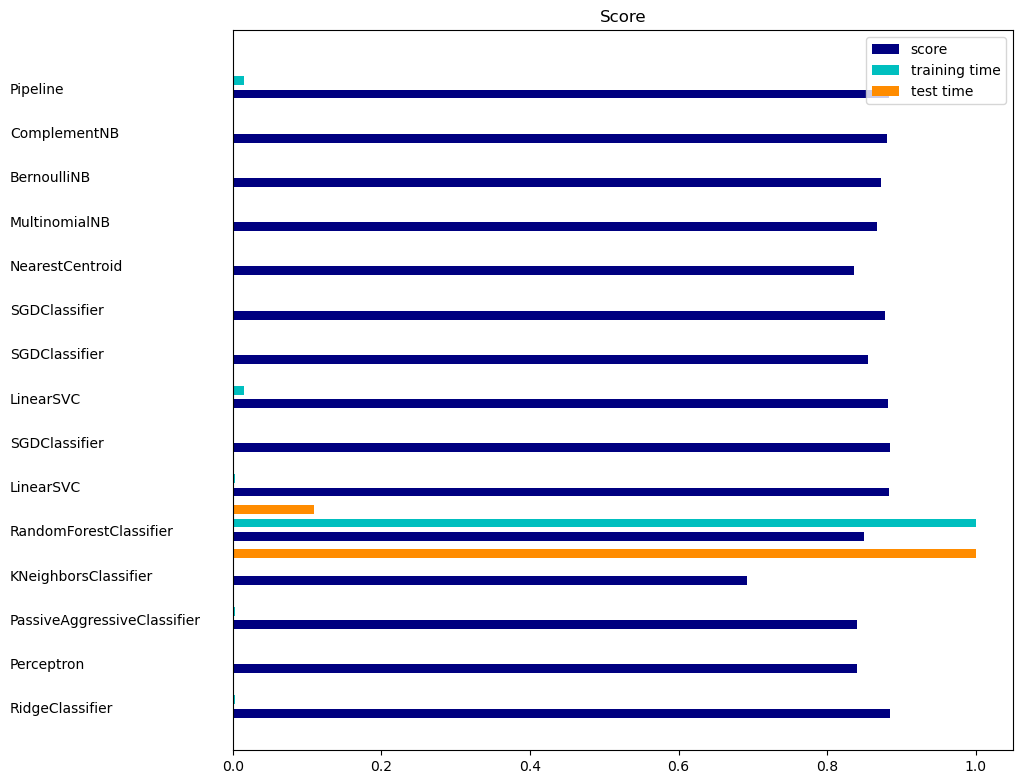

In [58]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

The best scores are for accuracies around 0.88. As we can see the top performers in accuracy were: RidgeClassifier, LinearSVC, SGDClassifier, ComplementNB and Pipeline.  They were all really fast compared to the deep learning.  Let's see how all the model compare to the deep learning metrics. 

## Metrics to evaluate the models. 

I will compare the 4 deep learning models I ran above and the elasticnet machine learning models ranin the last section and compare them to find the best. 

There are 2 models using distilbert preprocessing, one using a triangular learning rate using the early stoping of the autofit, and the other using 2 cycles of sdgs, as it overfits with more cycles. I will call them distilbert_auto and distilbert_sdgs

The other 2 models trainined with keras and ktrain are with the 'standard' preprocess and using NBSVM models, one with ngram =1 and the other ngram=2 this will be called nbsvm_1 and nbsvm_2. 

To evaluate the model I load the data I saved in the evaluation files on the results predicted by the model and calculate their metrics. 

### Metrics calculations. 

In [154]:
eval_filesdl = glob.glob("%s/*Autofit_deep*" % EVAL_DIR)
y_test = np.asarray(pickle.load(open(eval_filesdl[0], 'rb')))
y_pred = pickle.load(open(eval_filesdl[1], 'rb'))


In [155]:
Model_name = ['distilbert_auto']
accuracy = [metrics.accuracy_score(y_test, y_pred).round(3)]
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = [confusion[1, 1]]
TN = [confusion[0, 0]]
FP = [confusion[0, 1]]
FN = [confusion[1, 0]]
print('distilbert_auto')
print(confusion)
class_error = [(1-metrics.accuracy_score(y_test, y_pred)).round(3)]
recall = [metrics.recall_score(y_test, y_pred).round(3)]
precision = [metrics.precision_score(y_test, y_pred).round(3)]
f1 = [metrics.f1_score(y_test, y_pred).round(3)]

DL = [ 'distilbert_sdgs','nbsvm_1','nbsvm_2']

for mname in DL:
    eval_files = glob.glob('%s/*%s*' % (EVAL_DIR, mname))
    y_test = np.asarray(pickle.load(open(eval_files[0], 'rb')))
    y_pred = pickle.load(open(eval_files[1], 'rb'))
    Model_name. append(mname)
    accuracy.append(metrics.accuracy_score(y_test, y_pred).round(3))
    confusion = metrics.confusion_matrix(y_test, y_pred)
    TP.append(confusion[1, 1])
    TN.append(confusion[0, 0])
    FP.append(confusion[0, 1])
    FN.append(confusion[1, 0])
    print(mname)
    print(confusion)
    class_error.append((1-metrics.accuracy_score(y_test, y_pred)).round(3))
    recall.append(metrics.recall_score(y_test, y_pred).round(3))
    precision.append(metrics.precision_score(y_test, y_pred).round(3))
    f1.append(metrics.f1_score(y_test, y_pred).round(3))


distilbert_auto
[[2659  168]
 [ 266 2324]]
distilbert_sdgs
[[2696  195]
 [ 261 2284]]
nbsvm_1
[[2624  272]
 [ 283 2160]]
nbsvm_2
[[2601  307]
 [ 304 2126]]


In [156]:
MN = list(np.unique(np.array(clf_names)))
    #pickle.dump(y_test, open('%s/y_test_%s.p' % (EVAL_DIR, model_name), 'wb'))

for mname in MN:
    eval_files = glob.glob('%s/*%s*' % (EVAL_DIR, mname))
    y_test = np.asarray(pickle.load(open(eval_files[0], 'rb')))
    y_pred = pickle.load(open(eval_files[1], 'rb'))
    Model_name. append(mname)
    accuracy.append(metrics.accuracy_score(y_test, y_pred).round(3))
    confusion = metrics.confusion_matrix(y_test, y_pred)
    TP.append(confusion[1, 1])
    TN.append(confusion[0, 0])
    FP.append(confusion[0, 1])
    FN.append(confusion[1, 0])
    print(mname)
    print(confusion)
    class_error.append((1-metrics.accuracy_score(y_test, y_pred)).round(3))
    recall.append(metrics.recall_score(y_test, y_pred).round(3))
    precision.append(metrics.precision_score(y_test, y_pred).round(3))
    f1.append(metrics.f1_score(y_test, y_pred).round(3))

BernoulliNB
[[2554  320]
 [ 371 2172]]
ComplementNB
[[2510  415]
 [ 234 2258]]
KNeighborsClassifier
[[1320 1605]
 [  66 2426]]
LinearSVC
[[2611  314]
 [ 323 2169]]
MultinomialNB
[[2551  374]
 [ 344 2148]]
NearestCentroid
[[2528  491]
 [ 397 2001]]
PassiveAggressiveClassifier
[[2462  463]
 [ 404 2088]]
Perceptron
[[2463  403]
 [ 462 2089]]
Pipeline
[[2605  320]
 [ 314 2178]]
RandomForestClassifier
[[2395  288]
 [ 530 2204]]
RidgeClassifier
[[2637  288]
 [ 338 2154]]
SGDClassifier
[[2664  397]
 [ 261 2095]]


In [157]:
metrics_df = pd.DataFrame({'Model_Name':Model_name, 
    'F1':f1, 
    'Precision':precision,
    'Recall': recall,
    'Accuracy':accuracy,
    'Class_Error':class_error,                       
    'Type_I_error': FP, 
    'Type_II_error': FN})


We can see that the deep learning models had  higher Accuracy and F1 metrics over the machine learning elasticnet model, the distilbert_auto was by far (only distilbert_sdgs was close), the one with the smallest amount of type I errors or false positives, this translates to being the model with the highest precision of 0.933, which means that in average out of 100 articles we choose to put the theragun advertisment 93 will in fact be of health and wellness, so the deep learning model is indeed the best model for the purpose of targeting the adds.  

The recall and type 2 error of distilbert_auto was ok but not the best among all the models, but for our purposes it is less important, as is ok if we miss some health and welness articles given that we were probably not planning on putting an add in absolutely every single health and welness add as the budget for such thing would be out of reach. 

In [158]:
metrics_df.sort_values(by = 'F1', ascending= False)

,Model_Name,F1,Precision,Recall,Accuracy,Class_Error,Type_I_error,Type_II_error
0,distilbert_auto,0.915,0.933,0.897,0.920,0.080,168,266
1,distilbert_sdgs,0.909,0.921,0.897,0.916,0.084,195,261
2,nbsvm_1,0.886,0.888,0.884,0.896,0.104,272,283
3,nbsvm_2,0.874,0.874,0.875,0.886,0.114,307,304
5,ComplementNB,0.874,0.845,0.906,0.880,0.120,415,234
12,Pipeline,0.873,0.872,0.874,0.883,0.117,320,314
14,RidgeClassifier,0.873,0.882,0.864,0.884,0.116,288,338
7,LinearSVC,0.872,0.874,0.870,0.882,0.118,314,323
15,SGDClassifier,0.864,0.841,0.889,0.879,0.121,397,261
4,BernoulliNB,0.863,0.872,0.854,0.872,0.128,320,371


In [160]:
metrics_df.Model_Name[1] = 'distilbert_SGDR'



/var/folders/n5/yyv4zxgx3xb4rdrwt70vgb380000gn/T/ipykernel_1670/238085103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df.Model_Name[1] = 'distilbert_SGDR'


In [162]:
metrics_df.sort_values(by = 'Precision', ascending= False)

,Model_Name,F1,Precision,Recall,Accuracy,Class_Error,Type_I_error,Type_II_error
0,distilbert_auto,0.915,0.933,0.897,0.920,0.080,168,266
1,distilbert_SGDR,0.909,0.921,0.897,0.916,0.084,195,261
2,nbsvm_1,0.886,0.888,0.884,0.896,0.104,272,283
13,RandomForestClassifier,0.843,0.884,0.806,0.849,0.151,288,530
14,RidgeClassifier,0.873,0.882,0.864,0.884,0.116,288,338
3,nbsvm_2,0.874,0.874,0.875,0.886,0.114,307,304
7,LinearSVC,0.872,0.874,0.870,0.882,0.118,314,323
4,BernoulliNB,0.863,0.872,0.854,0.872,0.128,320,371
12,Pipeline,0.873,0.872,0.874,0.883,0.117,320,314
8,MultinomialNB,0.857,0.852,0.862,0.867,0.133,374,344
